In [11]:
from pynwb import NWBHDF5IO
from fsspec import filesystem
from h5py import File
from dandi.dandiapi import DandiAPIClient
from tqdm.notebook import tqdm

DANDISET_ID = '000559'
hek_path = 'sub-HEK293'
file_paths = [
    hek_path + '/sub-HEK293_ses-exp3_ophys.nwb',
    hek_path + '/sub-HEK293_ses-exp4_ophys.nwb',
    hek_path + '/sub-HEK293_ses-exp5_ophys.nwb',
]
def stream_nwbfile(DANDISET_ID, file_path):
    '''Stream NWB file from DANDI archive.
    
    Parameters
    ----------
    DANDISET_ID : str
        Dandiset ID
    file_path : str
        Path to NWB file in DANDI archive
    
    Returns
    -------
    nwbfile : NWBFile
        NWB file
    io : NWBHDF5IO
        NWB IO object (for closing)
        
    Notes
    -----
    The io object must be closed after use.
    '''
    with DandiAPIClient() as client:
        asset = client.get_dandiset(DANDISET_ID, 'draft').get_asset_by_path(file_path)
        s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)
    fs = filesystem("http")
    file_system = fs.open(s3_url, "rb")
    file = File(file_system, mode="r")
    io = NWBHDF5IO(file=file, load_namespaces=True)
    nwbfile = io.read()
    return nwbfile, io

nwbfiles, ios = zip(*[stream_nwbfile(DANDISET_ID, file_path) for file_path in tqdm(file_paths)])

  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
from skimage.io import imread
import tifffile
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from pathlib import Path
from neuroconv.datainterfaces import TiffImagingInterface
from pynwb import NWBHDF5IO

plt.rcParams.update(plt.rcParamsDefault)

from tqdm.auto import tqdm
from skimage.io import imread
from skimage import morphology
from skimage import filters
from skimage import measure, draw
from cellpose import models
from scipy.optimize import curve_fit
from scipy.stats import zscore
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd


def reproduce_figS1abcd(file_paths, nwbfiles):
    model = models.Cellpose(model_type="cyto2", gpu=True)
    parameters = [
        {"lag": int(5), "trim": np.inf, "start": 5, "onset": 88, "offset": 200},
        {"lag": int(5), "trim": int(135), "start": 5, "onset": 40, "offset": np.inf},
        {"lag": int(5), "trim": int(280), "start": 5, "onset": 50, "offset": 170},
    ]
    hampel_parameters = {"win": 10, "threshold": 2}
    channels = [0, 0]

    results = nested_dict()
    baseline_func = bi_exp_decay
    baseline_kwargs = {"p0": (0.5, -1e-3, 0.5, -1e-3, 0), "maxfev": int(1e5)}
    fallback_func = linear_decay
    fallback_kwargs = {"p0": (-0.1, 0), "maxfev": int(1e3)}

    for file_path, nwbfile, _parameters in tqdm(zip(file_paths, nwbfiles, parameters), total=len(parameters)):
        raw_signal = np.array(nwbfile.acquisition["Signal1PSeries"].data)
        raw_reference = np.array(nwbfile.acquisition["Reference1PSeries"].data)
        scale_dat = np.array(nwbfile.acquisition["Images"]["ScaleImage"].data)
        grid_spacing_um = nwbfile.imaging_planes["ReferenceImagingPlane"].grid_spacing[0]
        masks, flows, styles, diams = model.eval(
            (np.max(raw_signal[:25], axis=0)),
            diameter=None,
            channels=channels,
            cellprob_threshold=0,
        )

        props = measure.regionprops(masks)

        diameters = np.array([_.major_axis_length for _ in props])
        centroids = np.array([_.centroid for _ in props])

        cells = np.unique(masks)
        cells = cells[cells > 0]
        cells = cells[diameters > 30]
        centroids = centroids[diameters > 30]

        traces_dlight = []
        traces_isos = []
        for _cell, _centroid in zip(cells, centroids):
            rr, cc = draw.disk(_centroid, 7)
            _cell_mask = masks == _cell
            _cell_mask[rr, cc] = 0

            _cell_trace = []
            for _raw_dat in raw_signal:
                _cell_trace.append(_raw_dat[_cell_mask].mean())
            traces_dlight.append(simple_hampel(np.array(_cell_trace), **hampel_parameters))
            _cell_trace = []
            for _raw_dat in raw_reference:
                _cell_trace.append(_raw_dat[_cell_mask].mean())
            traces_isos.append(simple_hampel(np.array(_cell_trace), **hampel_parameters))

        traces_dlight = np.array(traces_dlight)
        traces_isos = np.array(traces_isos)

        right_edge = int(np.minimum(_parameters["trim"], traces_dlight.shape[1]))
        xvec = np.arange(_parameters["start"], right_edge)
        baseline = np.arange(0, _parameters["onset"] - _parameters["start"])
        if _parameters["offset"] < len(xvec):
            post_stim = np.arange(_parameters["offset"] - _parameters["start"], len(xvec))
            use_region = np.concatenate([baseline, post_stim])
        else:
            use_region = baseline

        trim_traces_dlight = traces_dlight[:, xvec]
        trim_traces_isos = traces_isos[:, xvec]

        traces_dlight_baserem = np.zeros_like(trim_traces_dlight)
        baseline_dlight = np.zeros_like(trim_traces_dlight)

        for i, _trace in tqdm(enumerate(trim_traces_dlight), total=len(trim_traces_dlight)):
            offset = _trace[0]
            try:
                params = curve_fit(baseline_func, use_region, _trace[use_region] - offset, **baseline_kwargs)
                fit_curve = baseline_func(xvec, *params[0]) + offset
            except:
                params = curve_fit(fallback_func, use_region, _trace[use_region] - offset, **fallback_kwargs)
                fit_curve = fallback_func(xvec, *params[0]) + offset
            traces_dlight_baserem[i] = (_trace - fit_curve) / fit_curve
            baseline_dlight[i] = fit_curve

        traces_isos_baserem = np.zeros_like(trim_traces_dlight)
        baseline_isos = np.zeros_like(trim_traces_dlight)

        for i, _trace in tqdm(enumerate(trim_traces_isos), total=len(trim_traces_isos)):
            offset = _trace[0]
            try:
                params = curve_fit(baseline_func, use_region, _trace[use_region] - offset, **baseline_kwargs)
                fit_curve = baseline_func(xvec, *params[0]) + offset
            except:
                params = curve_fit(fallback_func, use_region, _trace[use_region] - offset, **fallback_kwargs)
                fit_curve = fallback_func(xvec, *params[0]) + offset
            traces_isos_baserem[i] = (_trace - fit_curve) / fit_curve
            baseline_isos[i] = fit_curve

        results[file_path]["dlight"]["baseline_rem"] = traces_dlight_baserem
        results[file_path]["isos"]["baseline_rem"] = traces_isos_baserem
        results[file_path]["dlight"]["raw"] = trim_traces_dlight
        results[file_path]["isos"]["raw"] = trim_traces_isos
        results[file_path]["dlight"]["fit_baseline"] = baseline_dlight
        results[file_path]["isos"]["fit_baseline"] = baseline_isos
        results[file_path]["rois"] = masks

    onsets = np.array([_["onset"] for _ in parameters])
    lens = np.array([len(_["dlight"]["baseline_rem"][0]) for _ in results.values()])
    max_onset = onsets.max()
    diffs_onset = max_onset - np.array(onsets)
    lens += diffs_onset
    max_lens = lens.max()
    diffs_len = max_lens - lens
    padder = lambda x, y, z: np.pad(x, [(0, 0), (y, z)], mode="constant", constant_values=np.nan)
    dlight_traces = [_["dlight"]["baseline_rem"] for _ in results.values()]
    isos_traces = [_["isos"]["baseline_rem"] for _ in results.values()]
    dlight_traces_raw = [_["dlight"]["raw"] for _ in results.values()]
    isos_traces_raw = [_["isos"]["raw"] for _ in results.values()]
    dlight_traces = [padder(_, _onset, _offset) for _, _onset, _offset in zip(dlight_traces, diffs_onset, diffs_len)]
    isos_traces = [padder(_, _onset, _offset) for _, _onset, _offset in zip(isos_traces, diffs_onset, diffs_len)]
    dlight_traces_raw = [
        padder(_, _onset, _offset) for _, _onset, _offset in zip(dlight_traces_raw, diffs_onset, diffs_len)
    ]
    isos_traces_raw = [
        padder(_, _onset, _offset) for _, _onset, _offset in zip(isos_traces_raw, diffs_onset, diffs_len)
    ]
    dlight_traces = np.vstack(dlight_traces)
    isos_traces = np.vstack(isos_traces)
    dlight_traces_raw = np.vstack(dlight_traces_raw)
    isos_traces_raw = np.vstack(isos_traces_raw)
    use_onset = 100
    use_duration = 15
    use_offset = 0
    maxvals = np.nanmax(dlight_traces[:, use_onset + use_offset : use_onset + use_duration], axis=1)
    use_rois = maxvals > 0.05
    clean_image = lambda x: filters.median(x, morphology.disk(3))
    max_projs_dlight = []
    max_projs_isos = []
    max_projs_masks = []
    for file_path, nwbfile in zip(file_paths, nwbfiles):
        raw_signal = np.array(nwbfile.acquisition["Signal1PSeries"].data)
        raw_reference = np.array(nwbfile.acquisition["Reference1PSeries"].data)
        max_projs_dlight.append(clean_image(np.max(raw_signal[:25], axis=0)))
        max_projs_isos.append(clean_image(np.max(raw_reference[:25], axis=0)))
        max_projs_masks.append(results[file_path]["rois"] > 0)
    rng = np.random.default_rng(0)

    plot1c(dlight_traces, isos_traces, max_onset, use_rois)
    plot_1d(
        baseline_func,
        baseline_kwargs,
        dlight_traces,
        isos_traces,
        results,
        use_rois,
        use_onset,
        use_offset,
        use_duration,
        rng,
    )
    plot_1a(max_projs_dlight, max_projs_isos, scale_dat, grid_spacing_um)
    plot_1b(max_projs_dlight, max_projs_isos, max_projs_masks, rng)

    for io in ios:
        io.close()


def plot_1b(max_projs_dlight, max_projs_isos, max_projs_masks, rng):
    x = np.concatenate([zscore(_[_mask].ravel()) for _, _mask in zip(max_projs_dlight, max_projs_masks)])
    y = np.concatenate([zscore(_[_mask].ravel()) for _, _mask in zip(max_projs_isos, max_projs_masks)])
    nans = np.isnan(x) | np.isnan(y)
    x = x[~nans]
    y = y[~nans]
    bootparams = []
    for _boot in tqdm(range(1000)):
        idx = rng.choice(np.arange(len(x)), size=len(x), replace=True)
        bootparams.append(curve_fit(linear_decay, x[idx], y[idx])[0])
    xvals = np.arange(x.min(), x.max())
    bootvals = []
    for _params in bootparams:
        bootvals.append(linear_decay(xvals, *_params))
    bootci = np.quantile(bootvals, [0.025, 0.975], axis=0)
    m, b = np.mean(bootparams, axis=0)
    mci, bci = np.std(bootparams, axis=0)
    fig, ax = plt.subplots(1, figsize=(4, 4))
    ax.scatter(x, y, 0.15, alpha=0.5, rasterized=True)
    ax.axis("square")
    plt.xlim(-3, 8)
    plt.ylim(-3, 8)
    plt.xticks(np.arange(-3, 10, 3))
    plt.yticks(np.arange(-3, 10, 3))
    plt.plot(plt.xlim(), plt.ylim(), color=plt.rcParams["axes.edgecolor"], zorder=-100, lw=1.5)
    plt.xlabel("480 nm")
    plt.ylabel("400 nm")
    ax.plot(xvals, np.mean(bootvals, axis=0), color="b", zorder=-150, lw=0.5)
    ax.fill_between(
        xvals,
        bootci[1],
        bootci[0],
        color="b",
        alpha=0.75,
        zorder=-200,
        lw=0,
        edgecolor=None,
    )
    ax.set_title(f"400nm={m:.3f} * 480nm +/- {mci:.3f}")
    fig.tight_layout()
    fig.suptitle("Extended Data Figure 1b", y=1.05)
    plt.show()


def plot_1a(max_projs_dlight, max_projs_isos, scale_dat, grid_spacing_um):
    cmap = sns.dark_palette([0, 1, 0], as_cmap=True)
    kwargs = {"cmap": cmap}
    fig, ax = plt.subplots(3, 1, figsize=(4, 10))
    scale_bar_um = 20
    scale_bar_px = int(scale_bar_um / grid_spacing_um)
    plot_projs_dlight = max_projs_dlight[1].copy()
    plot_projs_dlight[10 : 10 + scale_bar_px, 15:25] = np.max(plot_projs_dlight)
    ax[0].imshow(np.flipud(plot_projs_dlight.T), **kwargs)
    ax[0].set_title("480 nm")
    ax[1].imshow(np.flipud(max_projs_isos[1].T), **kwargs)
    ax[1].set_title("400 nm")
    ax[2].imshow(np.flipud(scale_dat.T), **kwargs)
    ax[2].set_title("scale (.01 mm per div)")
    for _ax in ax:
        _ax.axis("off")
    fig.suptitle("Extended Data Figure 1a", y=0.95)
    plt.show()


def plot_1d(
    baseline_func,
    baseline_kwargs,
    dlight_traces,
    isos_traces,
    results,
    use_rois,
    use_onset,
    use_offset,
    use_duration,
    rng,
):
    _trace = list(results.values())[2]["dlight"]["raw"][10]
    use_region = np.concatenate([np.arange(50), np.arange(150, len(_trace))])
    xvec = np.arange(len(_trace))
    offset = _trace[0]
    baseline_kwargs["maxfev"] = int(1e6)
    params = curve_fit(baseline_func, use_region, _trace[use_region] - offset, **baseline_kwargs)
    fit_curve = baseline_func(xvec, *params[0]) + offset
    x = np.nanmean(dlight_traces[use_rois, use_onset + use_offset : use_onset + use_duration], axis=1)
    y = np.nanmean(isos_traces[use_rois, use_onset + use_offset : use_onset + use_duration], axis=1)
    nans = np.isnan(x) | np.isnan(y)
    x = x[~nans]
    y = y[~nans]
    bootparams = []
    for _boot in range(1000):
        idx = rng.choice(np.arange(len(x)), size=len(x), replace=True)
        bootparams.append(curve_fit(linear_decay, x[idx], y[idx])[0])
    xvals = np.arange(-5, 60)
    bootvals = []
    for _params in bootparams:
        bootvals.append(linear_decay(xvals, *_params))
    bootci = np.quantile(bootvals, [0.025, 0.975], axis=0)
    m, b = np.mean(bootparams, axis=0)
    mci, bci = np.std(bootparams, axis=0)
    fig, ax = plt.subplots(1, figsize=(4, 4))
    duration = 30
    plt.scatter(
        dlight_traces[use_rois, use_onset + use_offset : use_onset + duration].mean(axis=1) * 100,
        isos_traces[use_rois, use_onset + use_offset : use_onset + duration].mean(axis=1) * 100,
        20,
    )
    ax.axis("square")
    ax.set_ylim(-5, 60)
    ax.set_xlim(-5, 60)
    # plt.xticks(-.05, .6)
    ax.set_xticks(np.arange(-5, 65, 15))
    ax.set_yticks(np.arange(-5, 65, 15))
    ax.set_xlabel("480 excitation")
    ax.set_ylabel("400 excitation")
    ax.plot(
        ax.get_xlim(),
        ax.get_ylim(),
        color=plt.rcParams["axes.edgecolor"],
        lw=1,
        zorder=-100,
    )
    ax.plot(xvals, np.mean(bootvals, axis=0), color="b", zorder=-150, lw=0.5)
    ax.fill_between(xvals, bootci[1], bootci[0], color="b", alpha=0.5, zorder=-200, edgecolor=None, lw=0)
    ax.set_title(f"400nm={m:.3f} * 480nm +/- {mci:.3f}")
    fig.tight_layout()
    fig.suptitle("Extended Data Figure 1d", y=1.05)
    plt.show()


def plot1c(dlight_traces, isos_traces, max_onset, use_rois):
    camera_fs = 0.25
    xticks = np.array([0, 210])
    xticklabels = (xticks / camera_fs) / 60
    cmap = plt.matplotlib.cm.magma.copy()
    kwargs = {
        "aspect": "auto",
        "norm": plt.matplotlib.colors.Normalize(vmin=0, vmax=0.25),
        "cmap": cmap,
    }
    cmap.set_bad(cmap(kwargs["norm"](0)))
    sns.set_context("paper")
    fig, ax = plt.subplots(1, 2, figsize=(5, 4), sharey=True, sharex=True)
    ax[0].imshow(dlight_traces[use_rois], **kwargs)
    ax[0].set_title("480 nm")
    ax[0].set_yticks([])
    ax[0].set_ylabel("ROI")
    h = ax[1].imshow(isos_traces[use_rois], **kwargs)
    ax[1].set_title("400 nm")
    for _ax in ax:
        _ax.axvline(x=max_onset, color="w", linestyle="--")
        _ax.axvline(x=max_onset + 85, color="w", linestyle="--")

        _ax.set_xticks(xticks)
        _ax.set_xticklabels(xticklabels)
    fig.supxlabel("Time (minutes)")
    fig.tight_layout()
    fig.colorbar(h, ax=ax.ravel(), label="dF/F0")
    fig.suptitle("Extended Data Figure 1c", y=1.05)
    plt.show()


def bi_exp_decay(t, A1, K1, A2, K2, C):
    return A1 * np.exp(K1 * t) + A2 * np.exp(K2 * t) + C


def linear_decay(t, M, B):
    return M * t + B


def simple_hampel(trace, win=6, threshold=3):
    use_series = pd.Series(trace)
    meds = use_series.rolling(win, 1, center=True).median()
    mad = lambda x: (x - x.median()).abs().median()
    diffs = use_series.rolling(win, 1, center=True).apply(mad)
    threshold = diffs > threshold
    trace[threshold] = meds[threshold]
    return trace


def nested_dict():
    return defaultdict(nested_dict)


def lagged_diff(traces, lag, axis=0):
    if axis == 0:
        return traces[lag:] - traces[:-lag]
    else:
        return traces[:, lag:] - traces[:, :-lag]

  0%|          | 0/3 [00:00<?, ?it/s]

cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

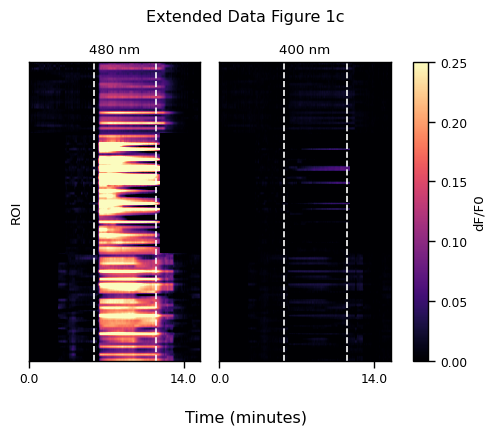

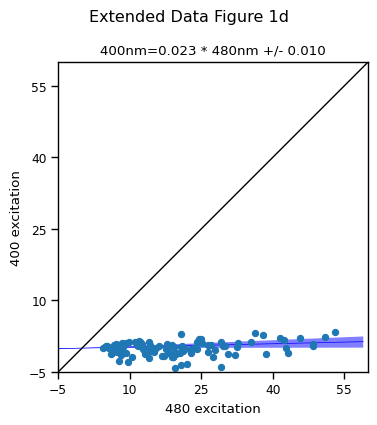

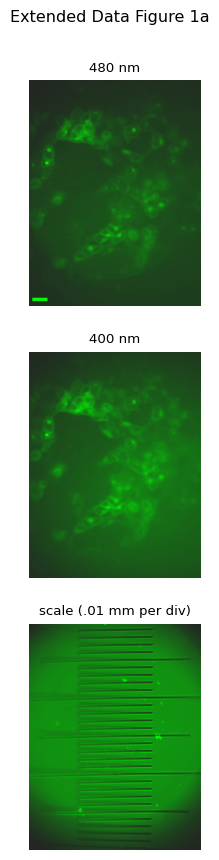

  0%|          | 0/1000 [00:00<?, ?it/s]

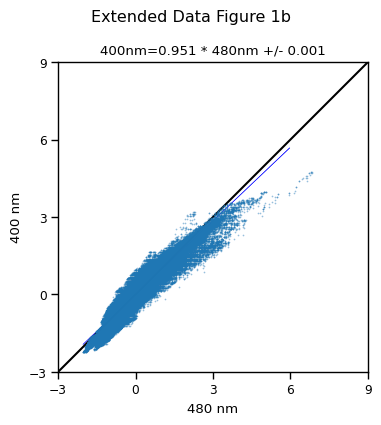

In [17]:
reproduce_figS1abcd(file_paths, nwbfiles)